# CICIDS2017 Dataset Preprocessing for Intrusion Detection System
This notebook focuses on the acquisition and preprocessing of the CICIDS2017 dataset for developing a machine learning-based intrusion detection system with reduced false positives.

### 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

###2. Dataset Acquisition

In [ ]:
# unzipping the data
!unzip /content/CICIDS2017.zip

Archive:  /content/CICIDS2017.zip
   creating: CICIDS2017/
  inflating: CICIDS2017/Friday-WorkingHours-Afternoon-DDos.csv  
  inflating: CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.csv  
  inflating: CICIDS2017/Friday-WorkingHours-Morning.csv  
  inflating: CICIDS2017/Monday-WorkingHours.csv  
  inflating: CICIDS2017/Thursday-WorkingHours-Afternoon-Infilteration.csv  
  inflating: CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.csv  
  inflating: CICIDS2017/Tuesday-WorkingHours.csv  
  inflating: CICIDS2017/Wednesday-workingHours.csv  


In [ ]:
# The directory where your CSV files are stored
data_directory = '/content/CICIDS2017'

# Get list of all CSV files in the directory
csv_files = glob.glob(os.path.join(data_directory, '*.csv'))
print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"- {os.path.basename(file)}")

Found 8 CSV files:
- Tuesday-WorkingHours.csv
- Thursday-WorkingHours-Afternoon-Infilteration.csv
- Thursday-WorkingHours-Morning-WebAttacks.csv
- Wednesday-workingHours.csv
- Monday-WorkingHours.csv
- Friday-WorkingHours-Afternoon-PortScan.csv
- Friday-WorkingHours-Morning.csv
- Friday-WorkingHours-Afternoon-DDos.csv


### 3. Data Loading and Combination

In [ ]:
def load_and_combine_cicids2017(file_paths):
    """
    Load and combine all CSV files from the CICIDS2017 dataset.

    Parameters:
    file_paths (list): List of file paths to CICIDS2017 CSV files

    Returns:
    pandas.DataFrame: Combined dataset
    """

    print("Loading and combining dataset files...")
    dataframes = []

    for file in file_paths:
        try:
            print(f"Processing: {os.path.basename(file)}")
            # The CICIDS2017 dataset has some formatting issues, so we need to handle them
            df = pd.read_csv(file, encoding='latin1', low_memory=False)

            # Standardize column names (remove spaces, lowercase)
            df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]

            # Rename the label column to ensure consistency across files
            if 'label' in df.columns:
                pass
            elif 'class' in df.columns:
                df.rename(columns={'class': 'label'}, inplace=True)
            elif ' label' in df.columns:
                df.rename(columns={' label': 'label'}, inplace=True)

            dataframes.append(df)
            print(f"Loaded {len(df)} rows, {len(df.columns)} columns")
        except Exception as e:
            print(f"Error loading {file}: {e}")

    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"\nCombined dataset shape: {combined_df.shape}")

    return combined_df

# Load and combine all CSV files
combined_data = load_and_combine_cicids2017(csv_files)

Loading and combining dataset files...
Processing: Tuesday-WorkingHours.csv
Loaded 445909 rows, 79 columns
Processing: Thursday-WorkingHours-Afternoon-Infilteration.csv
Loaded 288602 rows, 79 columns
Processing: Thursday-WorkingHours-Morning-WebAttacks.csv
Loaded 170366 rows, 79 columns
Processing: Wednesday-workingHours.csv
Loaded 692703 rows, 79 columns
Processing: Monday-WorkingHours.csv
Loaded 529918 rows, 79 columns
Processing: Friday-WorkingHours-Afternoon-PortScan.csv
Loaded 286467 rows, 79 columns
Processing: Friday-WorkingHours-Morning.csv
Loaded 191033 rows, 79 columns
Processing: Friday-WorkingHours-Afternoon-DDos.csv
Loaded 225745 rows, 79 columns

Combined dataset shape: (2830743, 79)


### 4. Initial Data Exploration

In [ ]:
# Display dataset information
print("\nDataset info:")
combined_data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  int64  
 5   total_length_of_bwd_packets  int64  
 6   fwd_packet_length_max        int64  
 7   fwd_packet_length_min        int64  
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        int64  
 11  bwd_packet_length_min        int64  
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes/s                 float64
 15  flow_packets/s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max               

In [ ]:
# Check unique values in the 'label' column
print("\nUnique attack types in the dataset:")
attack_counts = combined_data['label'].value_counts()
print(attack_counts)


Unique attack types in the dataset:
label
BENIGN                          2273097
DoS Hulk                         231073
PortScan                         158930
DDoS                             128027
DoS GoldenEye                     10293
FTP-Patator                        7938
SSH-Patator                        5897
DoS slowloris                      5796
DoS Slowhttptest                   5499
Bot                                1966
Web Attack ï¿½ Brute Force         1507
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: count, dtype: int64


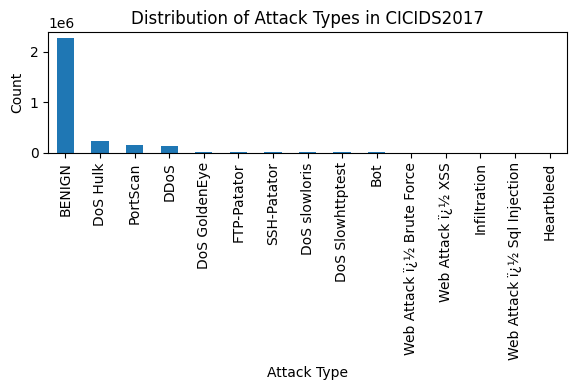

In [ ]:
# Visualize distribution of attacks
plt.figure(figsize=(6,4))
attack_counts.plot(kind='bar')
plt.title('Distribution of Attack Types in CICIDS2017')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('attack_distribution.png')
plt.show()
plt.close()


### 5. Data Cleaning

In [ ]:
def clean_cicids2017_data(df):
    """
    Clean the CICIDS2017 dataset by handling missing values,
    infinite values, and converting data types.

    Parameters:
    df (pandas.DataFrame): Combined CICIDS2017 dataset

    Returns:
    pandas.DataFrame: Cleaned dataset
    """
    print("\nCleaning the dataset...")

    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()

    # Check for missing values
    missing_values = cleaned_df.isnull().sum()
    print(f"Columns with missing values:\n{missing_values[missing_values > 0]}")

    # Handle missing values
    cleaned_df = cleaned_df.dropna(how='any', axis=0)
    print(f"Shape after removing rows with missing values: {cleaned_df.shape}")

    # Convert 'Infinity' values to NaN and then handle them
    cleaned_df = cleaned_df.replace([np.inf, -np.inf], np.nan)
    cleaned_df = cleaned_df.dropna(how='any', axis=0)
    print(f"Shape after handling infinite values: {cleaned_df.shape}")

    # Convert object columns to numeric if possible
    for col in cleaned_df.columns:
        if cleaned_df[col].dtype == 'object' and col != 'label':
            try:
                cleaned_df[col] = pd.to_numeric(cleaned_df[col])
                print(f"Converted column '{col}' to numeric")
            except:
                print(f"Could not convert column '{col}' to numeric")

    # Standardize label values (ensure all are strings and properly formatted)
    cleaned_df['label'] = cleaned_df['label'].astype(str).str.strip()

    # Convert benign/normal labels to a consistent format
    cleaned_df['label'] = cleaned_df['label'].replace({'BENIGN': 'Benign', 'benign': 'Benign', 'normal': 'Benign'})

    # For binary classification, create a binary label (0 for benign, 1 for attack)
    cleaned_df['binary_label'] = cleaned_df['label'].apply(lambda x: 0 if x == 'Benign' else 1)

    return cleaned_df

# Clean the dataset
cleaned_data = clean_cicids2017_data(combined_data)

# Display basic statistics
print("\nBasic statistics after cleaning:")
print(cleaned_data.describe())


Cleaning the dataset...
Columns with missing values:
flow_bytes/s    1358
dtype: int64
Shape after removing rows with missing values: (2829385, 79)
Shape after handling infinite values: (2827876, 79)

Basic statistics after cleaning:
       destination_port  flow_duration  total_fwd_packets  \
count      2.827876e+06   2.827876e+06       2.827876e+06   
mean       8.061534e+03   1.480065e+07       9.368972e+00   
std        1.827432e+04   3.366750e+07       7.500527e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   1.550000e+02       2.000000e+00   
50%        8.000000e+01   3.133800e+04       2.000000e+00   
75%        4.430000e+02   3.239368e+06       5.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       total_backward_packets  total_length_of_fwd_packets  \
count            2.827876e+06                 2.827876e+06   
mean             1.040396e+01                 5.498522e+02   
std              9.978937e+02

### 6. Feature Analysis and Selection


Analyzing features...


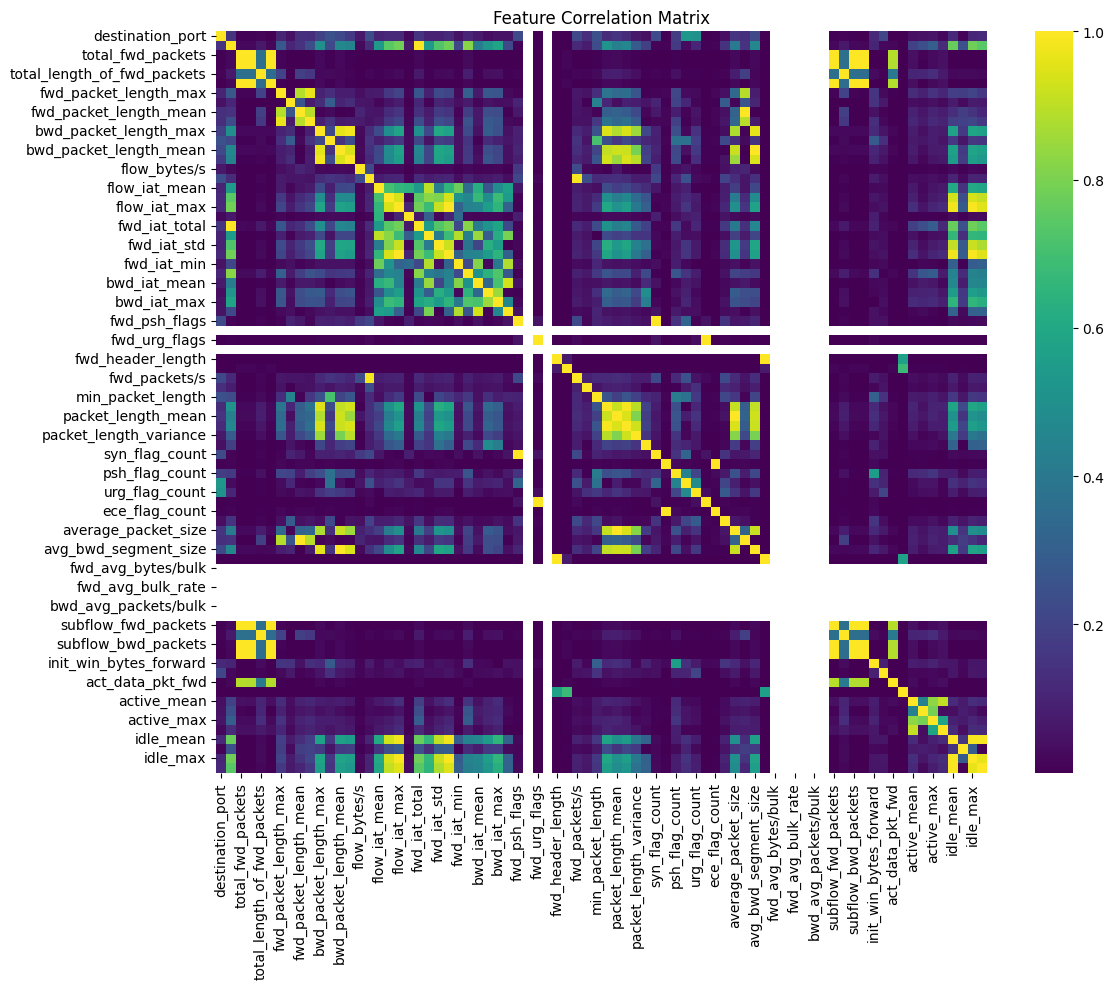

Found 23 highly correlated features that can be removed
Selected 30 features:
- destination_port
- flow_duration
- fwd_packet_length_max
- fwd_packet_length_min
- fwd_packet_length_mean
- bwd_packet_length_max
- bwd_packet_length_min
- flow_packets/s
- flow_iat_mean
- flow_iat_std
- flow_iat_max
- fwd_iat_mean
- fwd_iat_std
- fwd_iat_min
- bwd_iat_std
- bwd_iat_max
- bwd_iat_min
- fwd_psh_flags
- bwd_packets/s
- min_packet_length
- max_packet_length
- packet_length_mean
- packet_length_variance
- fin_flag_count
- psh_flag_count
- ack_flag_count
- urg_flag_count
- down/up_ratio
- init_win_bytes_backward
- idle_std

Verifying feature importance with Random Forest...


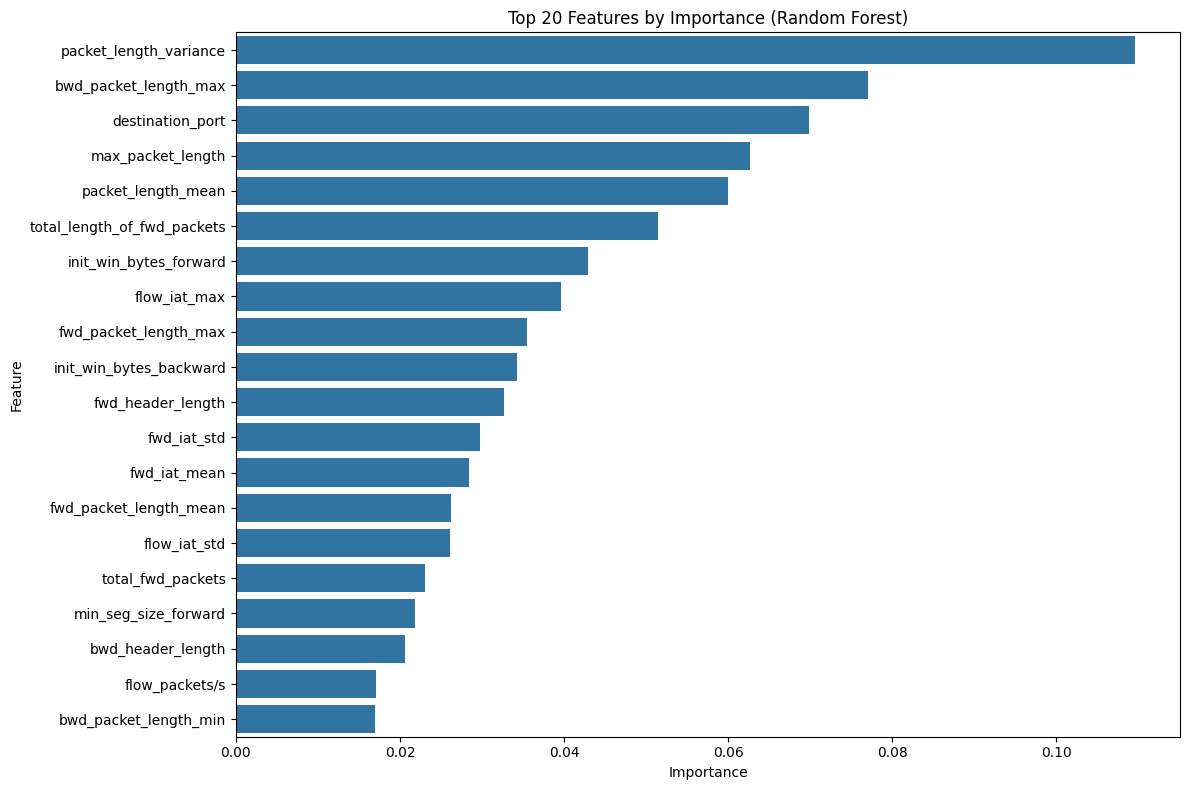

In [ ]:
def analyze_and_select_features(df, binary=True):
    """
    Analyze features and select the most relevant ones for intrusion detection.

    Parameters:
    df (pandas.DataFrame): Cleaned dataset
    binary (bool): Whether to use binary classification

    Returns:
    tuple: (X_selected, y, feature_names, selector)
    """
    print("\nAnalyzing features...")

    # Remove irrelevant columns (e.g., timestamps, flow IDs)
    irrelevant_cols = ['flow_id', 'source_ip', 'destination_ip', 'timestamp']
    drop_cols = [col for col in irrelevant_cols if col in df.columns]

    # Define features and target
    if binary:
        target_col = 'binary_label'
    else:
        target_col = 'label'

    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col, 'label', 'binary_label']]

    # Extract features and target
    X = df[feature_cols]
    y = df[target_col]

    # Correlation analysis
    plt.figure(figsize=(12, 10))
    corr_matrix = X.corr().abs()
    sns.heatmap(corr_matrix, cmap='viridis', vmax=1.0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    plt.savefig('feature_correlation.png')
    plt.close()

    # Identify highly correlated features (correlation > 0.95)
    highly_correlated = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > 0.95:
                colname = corr_matrix.columns[i]
                highly_correlated.add(colname)

    print(f"Found {len(highly_correlated)} highly correlated features that can be removed")

    # Remove highly correlated features
    X_reduced = X.drop(columns=highly_correlated)

    # Select K best features using ANOVA F-value
    k = min(30, X_reduced.shape[1])  # Select top 30 features or less if there are fewer
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X_reduced, y)

    # Get names of selected features
    selected_features = X_reduced.columns[selector.get_support()]
    print(f"Selected {len(selected_features)} features:")
    for feature in selected_features:
        print(f"- {feature}")

    # Feature importance using Random Forest (alternative method)
    print("\nVerifying feature importance with Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_reduced, y)

    # Plot feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_reduced.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Features by Importance (Random Forest)')
    plt.tight_layout()
    plt.show()
    plt.savefig('feature_importance.png')
    plt.close()

    return X_selected, y, selected_features, selector

# Analyze and select features
X_selected, y, selected_features, selector = analyze_and_select_features(cleaned_data)

### 7. Data Normalization

In [ ]:
def normalize_features(X):
    """
    Normalize the selected features.

    Parameters:
    X (numpy.ndarray): Selected features

    Returns:
    numpy.ndarray: Normalized features
    """
    print("\nNormalizing features...")

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit and transform the data
    X_normalized = scaler.fit_transform(X)

    return X_normalized, scaler

# Normalize the selected features
X_normalized, scaler = normalize_features(X_selected)


Normalizing features...


### 8. Handle Class Imbalance


Handling class imbalance...
Class distribution before balancing:
binary_label
0    2271320
1     556556
Name: count, dtype: int64
Class distribution after balancing:
binary_label
0    1484149
1    1113112
Name: count, dtype: int64


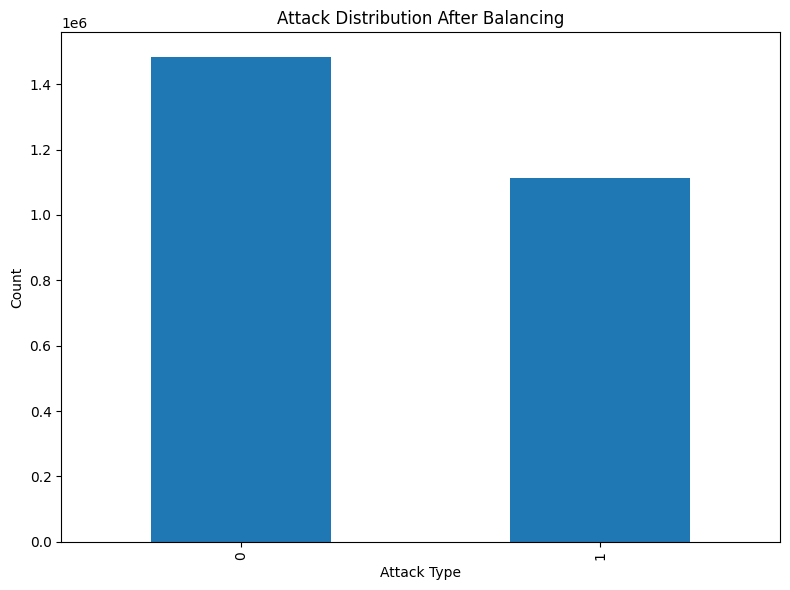

In [ ]:
def handle_class_imbalance(X, y):
    """
    Handle class imbalance using a combination of oversampling and undersampling.

    Parameters:
    X (numpy.ndarray): Normalized features
    y (pandas.Series): Target labels

    Returns:
    tuple: (X_balanced, y_balanced)
    """
    print("\nHandling class imbalance...")

    # Check class distribution
    class_counts = pd.Series(y).value_counts()
    print(f"Class distribution before balancing:\n{class_counts}")

    # For binary classification, use combination of SMOTE and undersampling
    if len(class_counts) == 2:
        # Calculate ratio for minority class (typically attacks)
        minority_ratio = min(0.5, class_counts.min() / class_counts.max() * 2)

        # Apply SMOTE to oversample the minority class
        sm = SMOTE(sampling_strategy=minority_ratio, random_state=42)
        X_over, y_over = sm.fit_resample(X, y)

        # Apply undersampling to reduce majority class
        rus = RandomUnderSampler(sampling_strategy=0.75, random_state=42)  # Aiming for roughly 3:1 ratio
        X_balanced, y_balanced = rus.fit_resample(X_over, y_over)

    # For multiclass, use SMOTE with lower ratios for very rare classes
    else:
        sm = SMOTE(sampling_strategy='auto', random_state=42)
        X_balanced, y_balanced = sm.fit_resample(X, y)

    # Check new class distribution
    balanced_counts = pd.Series(y_balanced).value_counts()
    print(f"Class distribution after balancing:\n{balanced_counts}")

    # Visualize the balanced distribution
    plt.figure(figsize=(8, 6))
    balanced_counts.plot(kind='bar')
    plt.title('Attack Distribution After Balancing')
    plt.xlabel('Attack Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    plt.savefig('balanced_distribution.png')
    plt.close()

    return X_balanced, y_balanced

# Handle class imbalance
X_balanced, y_balanced = handle_class_imbalance(X_normalized, y)

### 9. Train-Test Split

In [ ]:
def split_dataset(X, y):
    """
    Split the dataset into training and testing sets.

    Parameters:
    X (numpy.ndarray): Balanced features
    y (numpy.ndarray): Balanced labels

    Returns:
    tuple: (X_train, X_test, y_train, y_test)
    """
    print("\nSplitting dataset into training and testing sets...")

    # Split the data (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    return X_train, X_test, y_train, y_test

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(X_balanced, y_balanced)


Splitting dataset into training and testing sets...
Training set size: (1818082, 30)
Testing set size: (779179, 30)


### 10. Save Preprocessed Data

In [ ]:
def save_preprocessed_data(X_train, X_test, y_train, y_test, selected_features, scaler):
    """
    Save the preprocessed data for later use.

    Parameters:
    X_train, X_test, y_train, y_test: Train and test data
    selected_features: Names of selected features
    scaler: Fitted scaler object
    """
    print("\nSaving preprocessed data...")

    # Create directory for preprocessed data
    os.makedirs('preprocessed_data', exist_ok=True)

    # Save training and testing data
    np.save('preprocessed_data/X_train.npy', X_train)
    np.save('preprocessed_data/X_test.npy', X_test)
    np.save('preprocessed_data/y_train.npy', y_train)
    np.save('preprocessed_data/y_test.npy', y_test)

    # Save feature names
    pd.Series(selected_features).to_csv('preprocessed_data/selected_features.csv', index=False)

    # Save scaler
    import joblib
    joblib.dump(scaler, 'preprocessed_data/scaler.pkl')

    print("Preprocessed data saved successfully!")

# Save the preprocessed data
save_preprocessed_data(X_train, X_test, y_train, y_test, selected_features, scaler)


Saving preprocessed data...
Preprocessed data saved successfully!


### 11. Data Quality Assessment and Summary

In [ ]:
def assess_data_quality(original_df, cleaned_df, X_balanced, y_balanced):
    """
    Assess the quality of the preprocessed data.

    Parameters:
    original_df: Original combined dataset
    cleaned_df: Cleaned dataset
    X_balanced, y_balanced: Balanced features and labels
    """
    print("\nData Quality Assessment:")

    # Original data statistics
    print(f"Original data shape: {original_df.shape}")
    print(f"Original attack distribution:\n{original_df['label'].value_counts().head()}")

    # Cleaned data statistics
    print(f"\nCleaned data shape: {cleaned_df.shape}")
    print(f"Data reduction: {(1 - cleaned_df.shape[0]/original_df.shape[0])*100:.2f}%")

    # Final preprocessed data
    print(f"\nFinal preprocessed data shape: {X_balanced.shape}")
    print(f"Class balance in final data:\n{pd.Series(y_balanced).value_counts()}")

    # Summary visualization
    stages = ['Original', 'Cleaned', 'Balanced']
    row_counts = [original_df.shape[0], cleaned_df.shape[0], len(y_balanced)]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=stages, y=row_counts)
    plt.title('Dataset Size at Different Preprocessing Stages')
    plt.ylabel('Number of Records')
    plt.tight_layout()
    plt.savefig('preprocessing_summary.png')
    plt.close()

    print("\nPreprocessing complete! Dataset is ready for model training.")

# Assess data quality
assess_data_quality(combined_data, cleaned_data, X_balanced, y_balanced)


Data Quality Assessment:
Original data shape: (2830743, 79)
Original attack distribution:
label
BENIGN           2273097
DoS Hulk          231073
PortScan          158930
DDoS              128027
DoS GoldenEye      10293
Name: count, dtype: int64

Cleaned data shape: (2827876, 80)
Data reduction: 0.10%

Final preprocessed data shape: (2597261, 30)
Class balance in final data:
binary_label
0    1484149
1    1113112
Name: count, dtype: int64

Preprocessing complete! Dataset is ready for model training.


### 12. Conclusion

In [ ]:
print("""
# Preprocessing Summary

This notebook has successfully completed the acquisition and preprocessing of the CICIDS2017 dataset:

1. Loaded and combined multiple CSV files from the CICIDS2017 dataset
2. Cleaned the data by handling missing values and infinite values
3. Performed feature analysis and selection to identify the most relevant features
4. Normalized the features to improve model performance
5. Addressed class imbalance to ensure balanced representation of attack types
6. Split the data into training and testing sets
7. Saved the preprocessed data for the next phase

The dataset is now ready for Phase 2: Model Development and Training.

Next steps:
- Develop and train multiple ML classifiers
- Optimize hyperparameters to reduce false positives
- Evaluate model performance
- Implement feature importance analysis
""")


# Preprocessing Summary

This notebook has successfully completed the acquisition and preprocessing of the CICIDS2017 dataset:

1. Loaded and combined multiple CSV files from the CICIDS2017 dataset
2. Cleaned the data by handling missing values and infinite values
3. Performed feature analysis and selection to identify the most relevant features
4. Normalized the features to improve model performance
5. Addressed class imbalance to ensure balanced representation of attack types
6. Split the data into training and testing sets
7. Saved the preprocessed data for the next phase

The dataset is now ready for Phase 2: Model Development and Training.

Next steps:
- Develop and train multiple ML classifiers
- Optimize hyperparameters to reduce false positives
- Evaluate model performance
- Implement feature importance analysis



In [ ]:
# prompt: zip  this /content/preprocessed_data

!zip -r /content/preprocessed_data.zip /content/preprocessed_data


  adding: content/preprocessed_data/ (stored 0%)
  adding: content/preprocessed_data/y_train.npy (deflated 96%)
  adding: content/preprocessed_data/X_test.npy (deflated 64%)
  adding: content/preprocessed_data/selected_features.csv (deflated 63%)
  adding: content/preprocessed_data/y_test.npy (deflated 96%)
  adding: content/preprocessed_data/X_train.npy (deflated 64%)
  adding: content/preprocessed_data/scaler.pkl (deflated 57%)
